# Introduction
I really like pandas &ndash; the powerful data analysis framework for Python. And I really like pygal &ndash; an interactive visualization library written in and for Python.

**Why not put these two libraries together for effective data visualizations?**

In this blog post, I want to show you some basic use cases and integration tips between pandas as pygal.



# Data
We need some kind of data. Which one doesn't realy matter. Here I have a dataset that was produced to measure the utilization of source code during a program execution. It shows the lines of source code that were executed (covered) or missed during a production coverage measurement.

As usual, we load this data with pandas first.

In [1]:
import pandas as pd

raw = pd.read_csv("datasets/jacoco_production_coverage_spring_petclinic.csv")
raw.head()

,PACKAGE,CLASS,LINE_MISSED,LINE_COVERED
0,org.springframework.samples.petclinic,PetclinicInitializer,0,24
1,org.springframework.samples.petclinic.model,NamedEntity,1,4
2,org.springframework.samples.petclinic.model,Specialty,0,1
3,org.springframework.samples.petclinic.model,PetType,0,1
4,org.springframework.samples.petclinic.model,Vets,4,0


Let's add some columns to make this data better consumable.

In [2]:
df = pd.DataFrame(index=raw.index)
df['class'] = raw['PACKAGE'] + "." + raw['CLASS']
df['lines'] = raw['LINE_MISSED'] + raw['LINE_COVERED']
df['coverage'] = raw['LINE_COVERED'] / df['lines']
df.head()

,class,lines,coverage
0,org.springframework.samples.petclinic.Petclini...,24,1.0
1,org.springframework.samples.petclinic.model.Na...,5,0.8
2,org.springframework.samples.petclinic.model.Sp...,1,1.0
3,org.springframework.samples.petclinic.model.Pe...,1,1.0
4,org.springframework.samples.petclinic.model.Vets,4,0.0


# Visualization
## Basics

The core idea is to let pandas create the data in a format that pygal's visualizations can consume easily. So let's have a look at what pygal expects as input data.

Here is a basic example for a bar chart (adopted from [pygal's documentation](http://www.pygal.org/en/stable/documentation/types/line.html)) and take a look at the visualization.

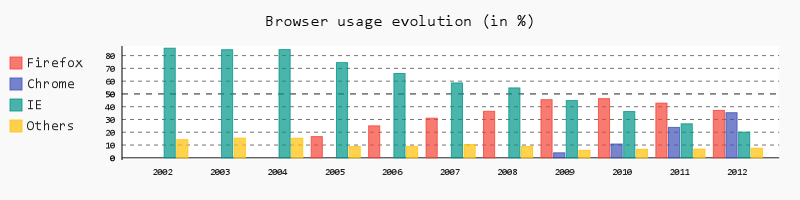

In [51]:
import pygal

bar_chart = pygal.Bar(height=200)
bar_chart.title = 'Browser usage evolution (in %)'
bar_chart.x_labels = map(str, range(2002, 2013))
bar_chart.add('Firefox', [None, None,    0, 16.6,   25,   31, 36.4, 45.5, 46.3, 42.8, 37.1])
bar_chart.add('Chrome',  [None, None, None, None, None, None,    0,  3.9, 10.8, 23.8, 35.3])
bar_chart.add('IE',      [85.8, 84.6, 84.7, 74.5,   66, 58.6, 54.7, 44.8, 36.2, 26.6, 20.1])
bar_chart.add('Others',  [14.2, 15.4, 15.3,  8.9,    9, 10.4,  8.9,  5.8,  6.7,  6.8,  7.5])
bar_chart

One of the important lines it this one:
```python
bar_chart.add('Firefox', [None, None,    0, 16.6,   25,   31, 36.4, 45.5, 46.3, 42.8, 37.1])

```

For each bar chart category (like "Firefox" or "Chrome"), we need to call the `add` function and provide the data.

Let's go back to our own data data. First, we want to create a category that makes some kind of sense for our use case. Let's use the name of a technical aspect of a source code file as our category. We can find this information at a specific part in the `class` column (at least for most cases).

In [4]:
df['category'] = df['class'].str.split(".").str[-2]
df.head()

,class,lines,coverage,category
0,org.springframework.samples.petclinic.Petclini...,24,1.0,petclinic
1,org.springframework.samples.petclinic.model.Na...,5,0.8,model
2,org.springframework.samples.petclinic.model.Sp...,1,1.0,model
3,org.springframework.samples.petclinic.model.Pe...,1,1.0,model
4,org.springframework.samples.petclinic.model.Vets,4,0.0,model


## Bar chart
OK, let's try to create a bar chart for the coverage for each file based on this data as a first step to get into the basic mechanics of the integration between pandas and pygal.

In [5]:
mean_by_category = df.groupby('category')['coverage'].mean()
mean_by_category

category
jdbc         0.000000
jpa          0.691558
model        0.739048
petclinic    1.000000
service      0.888889
util         0.135417
web          0.639809
Name: coverage, dtype: float64

We just iterate over all entries and add these to the bar chart by using a list comprehension.

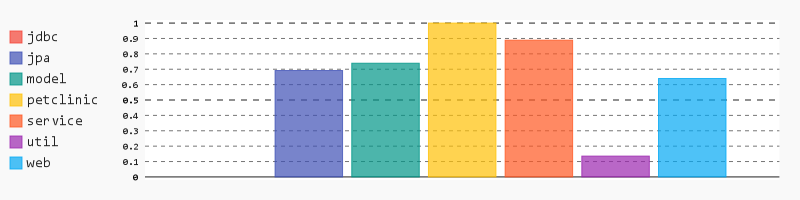

In [50]:
bar_chart = pygal.Bar(height=200)
[bar_chart.add(x[0], x[1]) for x in mean_by_category.items()]
bar_chart

So this is pretty standard and easy to do.

Let's look at a slightly more sophisticated use case: showing coverage values for all classes and color the classes accordingly to the category they belong to. But for this, a bar chart doesn't make any sense. So let's look at another visualization type.

## Treemap
The key idea is to use the pandas' `groupby`-function to get the data in a format that pygal can consume. The trick is to put all the `coverage`-values into a list for each category.

In [7]:
values_by_category = df.groupby(['category'])['coverage'].apply(list)
values_by_category

category
jdbc                  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
jpa          [0.5, 0.9090909090909091, 0.5, 0.8571428571428...
model        [0.8, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.65, 0.85...
petclinic                                                [1.0]
service                                   [0.8888888888888888]
util                       [0.0, 0.0, 0.0, 0.5416666666666666]
web          [0.6388888888888888, 0.9, 0.6, 0.7272727272727...
Name: coverage, dtype: object

This format is exactly what pygal needs. Let's create the treemap out of this data.

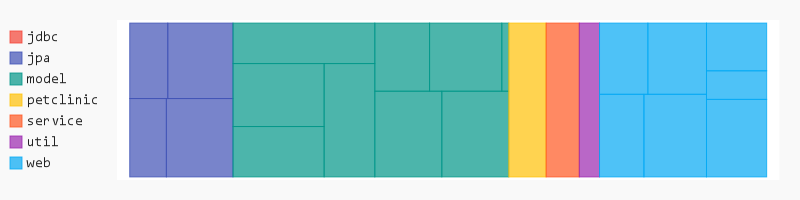

In [53]:
treemap = pygal.Treemap(height=200)
[treemap.add(x[0], x[1]) for x in values_by_category.items()]
treemap

BTW, we can easyly create an interactive HTML version by calling the `render_in_browser()`.

In [54]:
treemap.render_in_browser()

file://C:/Users/MARKUS~1/AppData/Local/Temp/tmp9q3vfccb.html


But what you might have been noticing is that the labels on a mousehover actions don't show the actual class name but rather the name of the category. Instead of passing a list of values, we need to differentiate between the actual value and the corresponding label for each value. We can do this by passing an appropriate dictionary.


```python
chart.add('category', [{'value' : 1, 'label': 'one'}, {'value': 2, 'label': 'two'}])
```

Let's fix this with another trick.

In [10]:
class_values_by_category = df.groupby(['category'], axis=0).apply(
    lambda x : [{"value" : y, "label" : z } for y, z in zip(x['coverage'], x['class'])])
class_values_by_category

category
jdbc         [{'value': 0.0, 'label': 'org.springframework....
jpa          [{'value': 0.5, 'label': 'org.springframework....
model        [{'value': 0.8, 'label': 'org.springframework....
petclinic    [{'value': 1.0, 'label': 'org.springframework....
service      [{'value': 0.8888888888888888, 'label': 'org.s...
util         [{'value': 0.0, 'label': 'org.springframework....
web          [{'value': 0.6388888888888888, 'label': 'org.s...
dtype: object

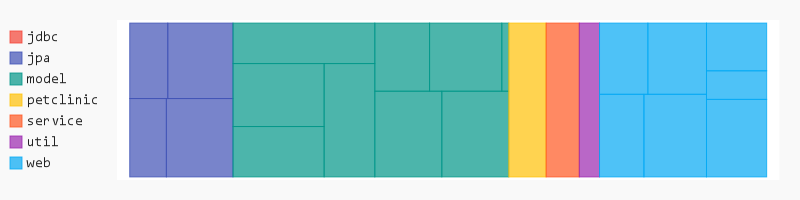

In [52]:
treemap = pygal.Treemap(height=200)
[treemap.add(x[0], x[1]) for x in class_values_by_category.iteritems()]
treemap

Here you can find the interactive version of this treemap. Note that if you hover over the tiles, you can now see the values and labels of the coverage or class respectively.

In [12]:
treemap.render_in_browser()

file://C:/Users/MARKUS~1/AppData/Local/Temp/tmpkqki9i9n.html


In the final step, I want to show you how you can colorize the tiles as needed. In our case, the column `coverage` is a perfect candidate for this, because it shows the ratio of executed code lines. A value near 1 means that almost all code lines were executed. A value near 0 means that the code line didn't ran.

Let's see if we can visualize this in the treemap, too. For this, we need two things:
- an indicator, that shows how much a class is covered (we have this information in the `coverage` column)
- a spectrum of colors that we want to use to show how strong the indicator per entry is (we could use the metapher of hot and cold for values near 1 and 0 respecively)

There are many ways to do it, but the most basic way is so assign every indicator value a corresponding color. For this, we'll us a red to blue colormap from matplot lib an draw colors appropriately.

In [13]:
from matplotlib.cm import coolwarm_r
from matplotlib.colors import rgb2hex

df['color'] = df['coverage'].apply(lambda x : rgb2hex(coolwarm_r(x)))
df.head()

,class,lines,coverage,category,color
0,org.springframework.samples.petclinic.Petclini...,24,1.0,petclinic,#3b4cc0
1,org.springframework.samples.petclinic.model.Na...,5,0.8,model,#7b9ff9
2,org.springframework.samples.petclinic.model.Sp...,1,1.0,model,#3b4cc0
3,org.springframework.samples.petclinic.model.Pe...,1,1.0,model,#3b4cc0
4,org.springframework.samples.petclinic.model.Vets,4,0.0,model,#b40426


In [14]:
class_ratios_by_category = df.groupby(['category'], axis=0).apply(
    lambda x : [
        {"value" : y,
         "label" : z,
         "color" : c} for y, z, c in zip(
            x['coverage'],
            x['class'],
            x['color'])])
class_ratios_by_category

category
jdbc         [{'value': 0.0, 'label': 'org.springframework....
jpa          [{'value': 0.5, 'label': 'org.springframework....
model        [{'value': 0.8, 'label': 'org.springframework....
petclinic    [{'value': 1.0, 'label': 'org.springframework....
service      [{'value': 0.8888888888888888, 'label': 'org.s...
util         [{'value': 0.0, 'label': 'org.springframework....
web          [{'value': 0.6388888888888888, 'label': 'org.s...
dtype: object

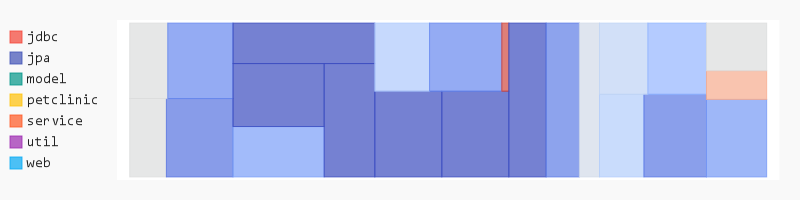

In [55]:
treemap = pygal.Treemap(height=200)
[treemap.add(x[0], x[1]) for x in class_ratios_by_category.iteritems()]
treemap

Let's, one more time, render this treemap as an interactive chart.

In [16]:
treemap.render_in_browser()

file://C:/Users/MARKUS~1/AppData/Local/Temp/tmpmgkihx7u.html


# Conclusion

Alright, that's it for this blog post! I hope you have seen that (if you know some tricks), you can easily integrate pandas with pygal!

I find this combination a great tradeoff between complexity and interactivity. Let me now if I can simplyfy or explain one or two things more deeply.

Maybe next time, we can take a look at some tricks regarding [D3](https://d3js.org/), right?
